## Multi-layer Perceptron Implementation
---------------------------------------
A [multi-layer perceptron](https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning) is a type of [feedforward neural network (FNN)](https://deepai.org/machine-learning-glossary-and-terms/feed-forward-neural-network). It is composed of fully connected layers and non-linear activation functions, and is commonly used for classifying data that cannot be separated by a straight line.

![MLP](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

### Input layer:
Each neuron represents a feature (e.g. petal length). This layer passes data forward without performing computation.

### Hidden layer:
Hidden layers form the core of the neural network. Neurons:

- Receive inputs from all previous-layer neurons (fully connected)
- Apply a weighted sum and a non-linear activation function (like ReLU)
- Learn by updating weights during training

### Output layer:
Generates the prediction. For classification tasks like the Iris dataset, each neuron can represent a class (e.g. setosa, versicolor, virginica).


Check out [Neural Network Playground](https://playground.tensorflow.org/) to experiment with layers, activations, and more.

## Step 1: Define the MLP model

In [12]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialise a simple feedforward MLP architecture.
        
        Parameters:
         input_size: Number of input features (e.g., 4 for Iris dataset)
         hidden_size: Number of neurons in the hidden layer
         num_classes: Number of output classes (e.g., 3 for Iris species)
        """
        super(MLP, self).__init__()
        
        # First layer (input to hidden)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
        # Second layer (hidden to hidden)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
        # Output layer (hidden to output)
        self.output = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification
        
    def forward(self, x):
        """
        Define the forward pass through the network for a single input.
        
        Parameter:
         x: Input tensor of shape [input_size] representing a single sample
        
        Returns:
         Output tensor of shape [num_classes] for a single prediction
        """

        # Forward pass through the network
        # Each step applies a linear transformation followed by a non-linear activation
        
        x = self.layer1(x)
        x = self.relu(x)
            
        x = self.layer2(x)
        x = self.relu(x)
            
        x = self.output(x)
        x = self.softmax(x)  # Apply softmax to get probabilities
        
        return x

## Step 2: Set model parameters and initialise model

In [13]:
input_size = 4    # Assuming 4 features (like Iris dataset)
hidden_size = 16  # Neurons in hidden layer
num_classes = 3   # Output classes 
model = MLP(input_size, hidden_size, num_classes)
model

MLP(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## Step 3: Loss function

In [14]:
def calculate_loss(model, X, y_true):
    """
    Calculate loss for the model without training.
    
    Parameters:
     model: The MLP model
     X: Input features (torch tensor) - single sample, not batched
     y_true: True label (torch tensor) - single label, not batched
    
    Returns:
     loss: Sum of squared errors loss value
    """
    
    # Add batch dimension of 1 for model compatibility
    X_input = X.unsqueeze(0)  # Adds batch dimension [1, input_features]
    y_pred = model(X_input)   # y_pred shape: [1, num_classes]
    
    # Get number of classes from model's output layer
    num_classes = model.output.out_features
    
    # Create one-hot encoded label for a single sample
    """
    as we are working with a classification problem that has 3 possible classes (0, 1, and 2). 
    Using one-hot encoding gives us:

    Class 0 becomes: [1, 0, 0]
    Class 1 becomes: [0, 1, 0]
    Class 2 becomes: [0, 0, 1]

    """
    y_true_one_hot = torch.zeros(1, num_classes)
    
    # Convert label tensor to integer and set the appropriate position to 1
    label_idx = y_true.item()
    y_true_one_hot[0, label_idx] = 1
    
    # Calculate sum of squared errors between prediction and one-hot label
    squared_errors = (y_pred - y_true_one_hot) ** 2
    loss = torch.sum(squared_errors)
    
    # Calculate and print the loss value
    loss_value = loss.item()
    
    # Return the loss as a Python float
    return loss_value

## Step 4: Prepare Iris Test Dataset

In [15]:
# In this step, the process is identical to the data handling steps in "DataPipeline" notebook.
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


# load the dataset
iris = load_iris()


# extract features and target classes
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# standardise the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


batch_size = 30
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Step 5: Evaluate Test Loss and Accuracy



Average SSE loss on test set (30 samples): 0.6946


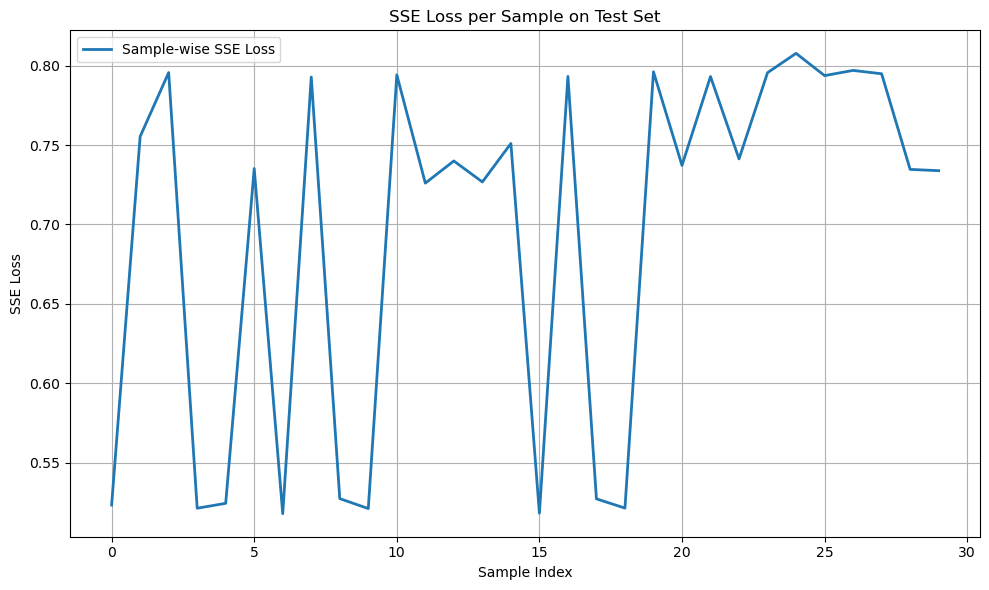

In [16]:
import matplotlib.pyplot as plt

# Initialise a list to store the individual losses
losses = []
# Evaluate the average SSE loss of the model on the test_dataset
model.eval()
total_test_loss = 0
num_test_samples = 0

with torch.no_grad():
    for features, labels in test_loader:
        for i in range(features.size(0)):
            # Extract individual feature and label
            single_feature = features[i]
            single_label = labels[i]

            # Calculate loss for individual sample
            loss = calculate_loss(model, single_feature, single_label)
            losses.append(loss)
            total_test_loss += loss
            num_test_samples += 1

# Calculate average loss across all processed samples
if num_test_samples > 0:
    avg_test_loss = total_test_loss / num_test_samples
    print(f"\nAverage SSE loss on test set ({num_test_samples} samples): {avg_test_loss:.4f}")
    
    # Plot the losses as a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_test_samples), losses, label='Sample-wise SSE Loss', color='tab:blue', linewidth=2)
    plt.xlabel("Sample Index")
    plt.ylabel("SSE Loss")
    plt.title("SSE Loss per Sample on Test Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Step 6: Implement Training Pipeline

### Setting the learning Rate

Ineuralep network trainingsettingng the learning rate over time is beneficial. With high learning rates, parameter vectors bounce chaotically, struggling to settle into optimal regions of the loss function. The timing of decay is crucial; too slow wastes computation, too fast prevents finding the best solution. The code below `optim.SGD(model.parameters(), lr=0.01)` creates a [Stochastic Gradient Descent optimiser](https://optimization.cbe.cornell.edu/index.php?title=Stochastic_gradient_descent) that will adjust the parameters of our model during training. It configures the optimiser to work with all the parameters in our model and sets the initial learning rate to `0.01`. This optimiser SGD is responsible for updating our model's weights based on the calculated gradients, helping the model to improve over time during the training process.er training.

In [17]:
import torch.optim as optim

# Set up optimiser which in our case is Stochastic Gradient Descent
optimiser = optim.SGD(model.parameters(), lr=0.01)

# nn.Module has a built in method called .parameters() which returns the model's parameters
# Related batches to learning rate

### Choosing number of epochs
Determining the optimal [number of epochs](https://deepai.org/machine-learning-glossary-and-terms/epoch) is crucial for neural network design. Too few, and our model will not learn properly; too many, and it may overfit, learning data noise rather than useful patterns. The right number is typically found through experimentation and monitoring performance on a validation set.

In [18]:
num_epochs = 100

# What is an epoch? One run of all the batches. 

As an exercise, you can try increasing or decreasing the number of epochs to analyse how it affects our training.

Epoch [10/100], Train Loss: 0.3186, Test Loss: 0.2978
Epoch [20/100], Train Loss: 0.1429, Test Loss: 0.1064
Epoch [30/100], Train Loss: 0.0566, Test Loss: 0.0433
Epoch [40/100], Train Loss: 0.0470, Test Loss: 0.0374
Epoch [50/100], Train Loss: 0.0447, Test Loss: 0.0299
Epoch [60/100], Train Loss: 0.0365, Test Loss: 0.0256
Epoch [70/100], Train Loss: 0.0398, Test Loss: 0.0254
Epoch [80/100], Train Loss: 0.0364, Test Loss: 0.0173
Epoch [90/100], Train Loss: 0.0342, Test Loss: 0.0241
Epoch [100/100], Train Loss: 0.0384, Test Loss: 0.0158


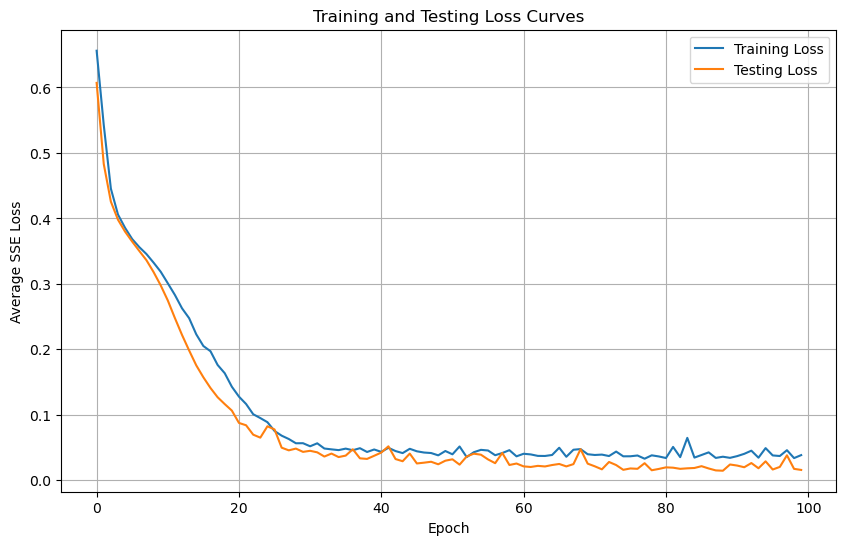

In [19]:
train_losses = []
test_losses = []  

# Training loop
for epoch in range(num_epochs):
    
    ### TRAINING PHASE
    model.train()  # Set to training mode
    total_loss = 0
    for features, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(features) 

        # create one-hot encoded labels into a format that allows us to calculate the loss
        one_hot = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1)
        loss = torch.sum((outputs - one_hot) ** 2)  # SSE loss
        
        loss.backward() # computes gradients of the loss with respect to model parameters using backpropagation
        optimiser.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    ### TESTING PHASE - Evaluate after each epoch
    model.eval()  # Set to evaluation mode
    test_total_loss = 0
    
    with torch.no_grad():  # No gradients needed for testing
        for features, labels in test_loader:
            outputs = model(features)
            one_hot = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1)
            test_loss = torch.sum((outputs - one_hot) ** 2) # SSE loss
            test_total_loss += test_loss.item()
    
    avg_test_loss = test_total_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    # Every 10 epochs, prints a progress update showing the current epoch number and the average training and test losses
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot training and testing loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Average SSE Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.grid(True)

And for classification problems it's good practise to visualise a confusion matrix to see how well our classifier predicts each class. We are using a very small, clean dataset here so it's not surprising that our MLP performs very well.

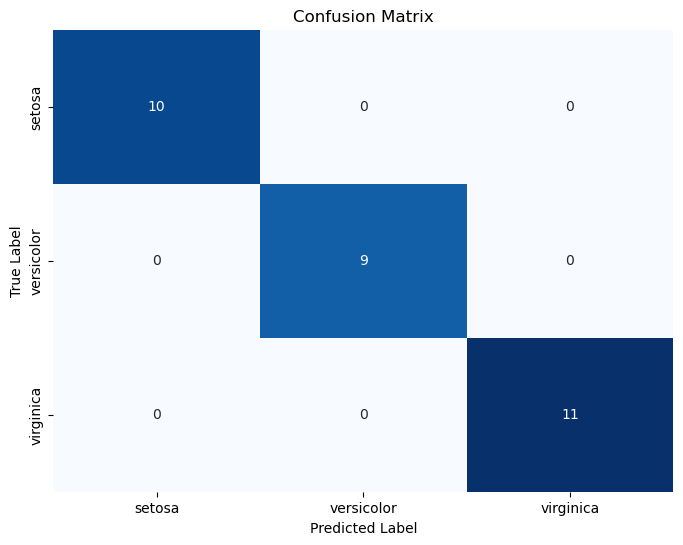

In [20]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions for the test set
y_pred = []
with torch.no_grad():
    for features, _ in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        y_pred.extend(predicted.numpy())
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()